# Practical Application Assignment 17.1: Comparing Classifiers to Predict Success of Marketing Campaign

## Data

In [79]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.stats.mstats import winsorize

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings(action= 'ignore')

import pickle

In [80]:
data = pd.read_csv("data/bank-additional-full.csv", sep= ";")
# data = pd.read_csv("data/bank.csv", sep= ";") # import part dataset of exploratory data analysis
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [81]:
data['y'].value_counts(normalize= True).reset_index()

,y,proportion
0,no,0.887346
1,yes,0.112654


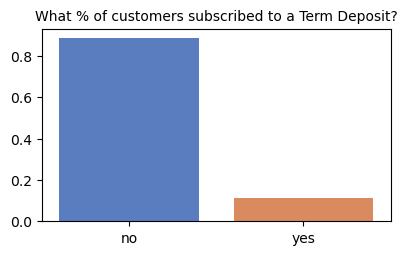

In [82]:
plt.figure(figsize= (4.5,2.5))
sns.barplot(data['y'].value_counts(normalize= True).reset_index(), hue= "y", y= "proportion", x= "y", legend= False,
            palette= sns.color_palette('muted'))
plt.xlabel('');
plt.ylabel('');
plt.title("What % of customers subscribed to a Term Deposit?", fontsize= 10)
plt.savefig("images/pct_yes.png")

## Exploratory Data Analysis

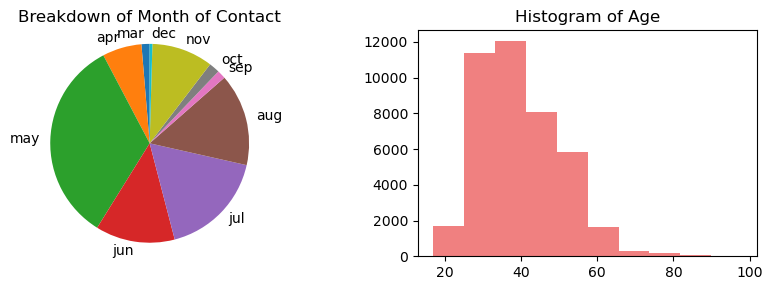

In [137]:
fig,axs = plt.subplots(figsize= (9,3), ncols= 2, width_ratios= [0.6, 0.4])

month_list = ['jan','feb','mar','apr','may','jun','jul','aug', 'sep','oct','nov','dec']
dt_month = data['month'].value_counts(normalize= True)
month_list = [mm for mm in month_list if mm in dt_month.index]
axs[0].pie(data['month'].value_counts(normalize= True).reindex(month_list).dropna(), labels= month_list, 
           startangle= 90, labeldistance= 1.1, radius= 1.1)
axs[0].set_title('Breakdown of Month of Contact', fontsize= 12)

axs[1].hist(data['age'], color= "lightcoral");
axs[1].set_title('Histogram of Age', fontsize= 12)


plt.tight_layout();
plt.savefig("images/age_month_breakdown.png")

1. The probability of a customer subscribing to a term deposit goes down as the number of contacts performed during this campaign increases.

In [84]:
# calculate custom buckets for time since last contact
# data.drop(['time_since_last_contact'], axis= 1, inplace= True)
data.loc[(data.pdays >= 0) & (data.pdays < 7), "time_since_last_contact"] = "<1 Wk"
data.loc[(data.pdays >= 7) & (data.pdays < 14), "time_since_last_contact"] = "1-2 Wk"
data.loc[(data.pdays >= 14) & (data.pdays < 30), "time_since_last_contact"] = "3-4 Wk"
# data.loc[(data.pdays >= 266) & (data.pdays < 99999), "time_since_last_contact"] = ">1 Y"
data['time_since_last_contact'] = data['time_since_last_contact'].fillna('NA')

In [85]:
# function to calculate probability of success
calc_success_rate = lambda x: (x=="yes").sum()/len(x)

# winsorize some of the numerical data
data['campaign'] = winsorize(data['campaign'], (0, 0.015)).astype(int)

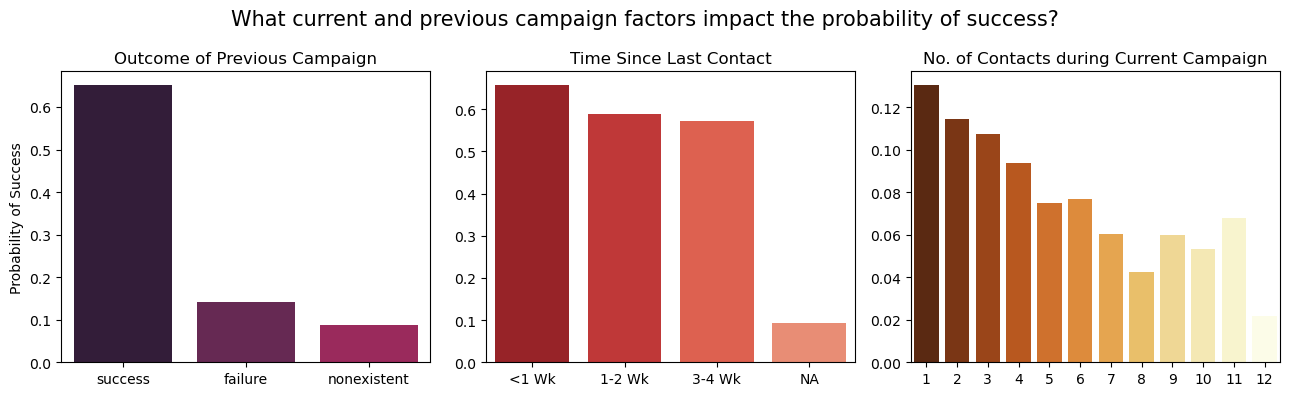

In [86]:
fig,axs = plt.subplots(figsize= (13,4), ncols= 3)

sns.barplot(data= data.groupby('poutcome')['y'].agg(calc_success_rate).reset_index(), x= "poutcome", y= "y", legend= False,
            ax= axs[0], palette= sns.color_palette("rocket"), hue= "poutcome", hue_order= ["nonexistent","failure", "success"][::-1],
            order= ["success", "failure", "nonexistent"])
axs[0].set_title("Outcome of Previous Campaign")
axs[0].xaxis.label.set_visible(False)
axs[0].set_ylabel("Probability of Success")


sns.barplot(data= data.groupby('time_since_last_contact')['y'].agg(calc_success_rate).reset_index(), 
            x= "time_since_last_contact", y= "y", legend= False, order= ["<1 Wk","1-2 Wk", "3-4 Wk", "NA"],
            hue_order= ["<1 Wk","1-2 Wk", "3-4 Wk", "NA"],
            ax= axs[1], palette= sns.color_palette('Reds_r'), hue= "time_since_last_contact")
axs[1].set_title("Time Since Last Contact")
axs[1].xaxis.label.set_visible(False)
axs[1].yaxis.label.set_visible(False)


sns.barplot(data= data.groupby('campaign')['y'].agg(calc_success_rate).reset_index(), x= "campaign", y= "y", legend= False,
            ax= axs[2], palette= sns.color_palette('YlOrBr_r', as_cmap= True), hue= "campaign")
axs[2].set_title("No. of Contacts during Current Campaign")
axs[2].xaxis.label.set_visible(False)
axs[2].yaxis.label.set_visible(False)


plt.suptitle("What current and previous campaign factors impact the probability of success?", fontsize= 15)
plt.tight_layout();
fig.savefig("images/previous_current_campaign.png")

#### How does timing of contact impact probability of success?

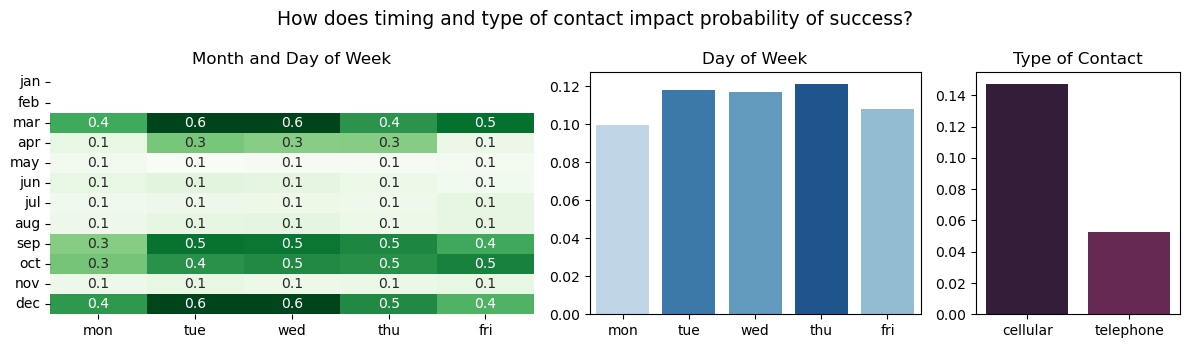

In [87]:
def format_func(value, tick_number):
    return f'{value:.1f}'


fig, axs = plt.subplots(figsize= (12,3.5), ncols= 3, width_ratios= [0.475, 0.325, 0.2])
sns.heatmap(pd.pivot_table(data= data, index= "month", columns= "day_of_week", values= 'y', aggfunc= calc_success_rate).\
            fillna(0).reindex(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])\
            [['mon','tue','wed','thu','fri']], ax= axs[0], annot= True, cbar= False, 
            cmap = sns.color_palette("Greens", as_cmap= True), fmt= "0.1f")
axs[0].set_xlabel('')
axs[0].set_ylabel("")
axs[0].set_title("Month and Day of Week")

sns.barplot(data.groupby('day_of_week')['y'].agg(calc_success_rate).reset_index(), x= "day_of_week", y= "y",  ax= axs[1],
            legend= False, hue= "day_of_week", palette= sns.color_palette("Blues_r"), order= ['mon','tue','wed','thu','fri'], 
            hue_order= ['thu','tue','wed','fri','mon'])
axs[1].set_xlabel('')
axs[1].set_ylabel("")
axs[1].set_title("Day of Week")
# axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

sns.barplot(data.groupby('contact')['y'].agg(calc_success_rate).reset_index(), x= "contact", y= "y",  ax= axs[2],
            legend= False, hue= "contact", palette= sns.color_palette("rocket"), )
axs[2].set_xlabel('')
axs[2].set_ylabel("")
axs[2].set_title("Type of Contact")
# axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.suptitle("How does timing and type of contact impact probability of success?", fontsize= 13.5)
plt.tight_layout();
plt.savefig("images/by_time_of_contact.png")

### How does demographic information impact the probability of success?

1. Demographics
2. Financial Information

In [8]:
data.loc[data.age<25, "age_group"] = "18-24"
data.loc[(data.age>=25) & (data.age<30), "age_group"] = "25-30"
data.loc[(data.age>=30) & (data.age<35), "age_group"] = "30-35"
data.loc[(data.age>=35) & (data.age<40), "age_group"] = "35-40"
data.loc[(data.age>=40) & (data.age<50), "age_group"] = "40-50"
data.loc[(data.age>=50) & (data.age<60), "age_group"] = "50-60"
data.loc[(data.age>=60) & (data.age<999), "age_group"] = ">60"

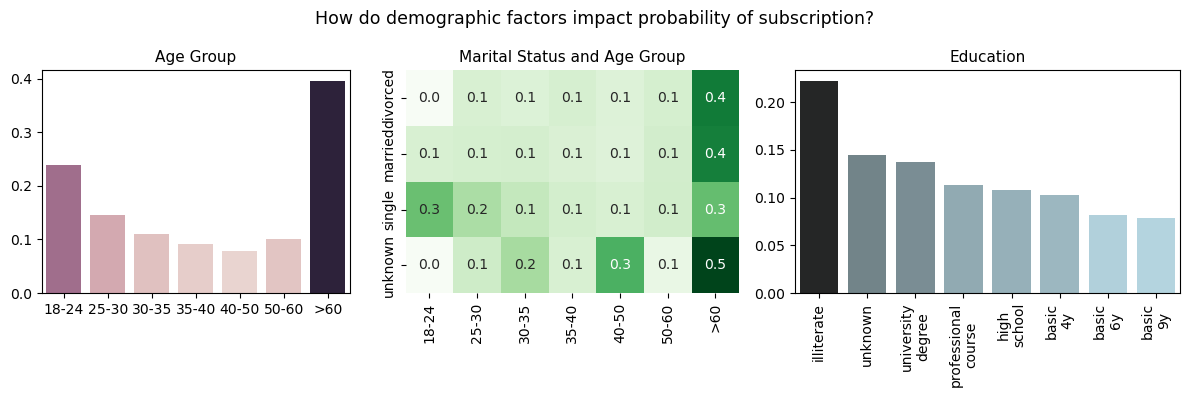

In [9]:
fig,axs = plt.subplots(figsize= (12,4), ncols= 3, width_ratios= [0.3, 0.325, 0.375])

sns.barplot(data.groupby('age_group')['y'].agg(calc_success_rate).reset_index(), x= "age_group", y= "y", ax= axs[0], 
            hue= "y", legend= False)
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_title("Age Group", fontsize= 11)

sns.heatmap(pd.pivot_table(data= data, index= "marital",  columns= "age_group",values= 'y', aggfunc= calc_success_rate).\
            fillna(0), annot= True, cbar= False, cmap = sns.color_palette("Greens", as_cmap= True), fmt= "0.1f", ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title("Marital Status and Age Group", fontsize= 11)
# axs[1].set_yticklabels(rotation=45)

dt_success_edu = data.groupby('education')['y'].agg(calc_success_rate).sort_values(ascending= False).reset_index()
sns.barplot(dt_success_edu, x= "education", y= "y", ax= axs[2], hue= "y", legend= False, color= "lightblue_r")
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_title("Education", fontsize= 11)
axs[2].tick_params(axis='x', labelrotation= 90)
axs[2].set_xticklabels(labels= dt_success_edu['education'].str.replace('.','\n'))

# Apply the format function to the y-axis
# axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.suptitle("How do demographic factors impact probability of subscription?",
             fontsize= 12.5)
plt.tight_layout();
fig.savefig("images/demographic_factors.png")

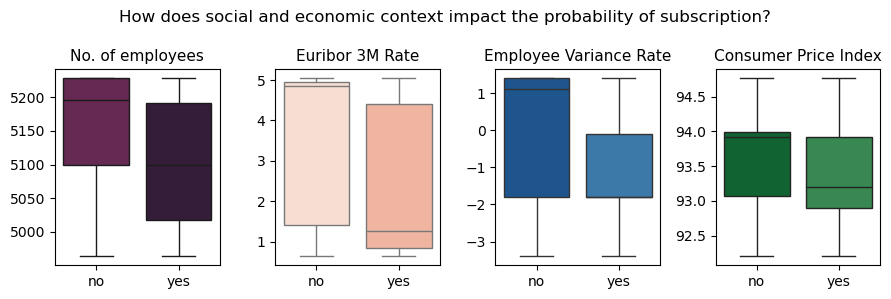

In [10]:
fig,axs = plt.subplots(figsize= (9,3), ncols= 4)

sns.boxplot(data= data, hue= "y", x= "y", y= "nr.employed", palette= sns.color_palette("rocket"), ax= axs[0], hue_order= ['yes','no'])
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_title("No. of employees", fontsize= 11)

sns.boxplot(data= data, hue= "y", x= "y", y= "euribor3m", palette= sns.color_palette("Reds"), ax= axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title("Euribor 3M Rate", fontsize= 11)

sns.boxplot(data= data, hue= "y", x= "y", y= "emp.var.rate", palette= sns.color_palette("Blues_r"), ax= axs[2])
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_title("Employee Variance Rate", fontsize= 11)

sns.boxplot(data= data, hue= "y", x= "y", y= "cons.price.idx", palette= sns.color_palette("Greens_r"), ax= axs[3])
axs[3].set_ylabel('')
axs[3].set_xlabel('')
axs[3].set_title("Consumer Price Index", fontsize= 11)

# sns.heatmap(pd.pivot_table(data= data, index= "housing",  columns= "loan",values= 'y', aggfunc= calc_success_rate).\
#             fillna(0).loc[['yes','no','unknown'],['yes','no','unknown']], annot= True, cbar= False, cmap = sns.color_palette("Blues", as_cmap= True), fmt= "0.2f", ax= axs[1])
# axs[1].set_title("Housing and Personal Loan?", fontsize= 11)

plt.suptitle("How does social and economic context impact the probability of subscription?",
             fontsize= 12)
plt.tight_layout();
fig.savefig("images/financial_factors.png")

## Modeling

### Feature Transfrom

In [11]:
target= 'y'
features = np.setdiff1d(data.columns, target).tolist()
features.remove('duration') # remove duration since nnot known before the call. does not influence targeting strategy.
features = np.setdiff1d(features, ['time_since_last_contact', 'age_group', 'week_no']).tolist()
data[target] = (data[target] == 'yes').astype(int)

cat_features= ['job', 'marital', 'education', 'contact', 'poutcome', 'month', 'day_of_week', 'default', 'housing', 'loan']
num_features = np.setdiff1d(features, cat_features).tolist()

col_transform = ColumnTransformer([
    ('oe', OneHotEncoder(drop= 'if_binary', min_frequency= 0.01, handle_unknown= 'ignore'), cat_features),
    ('poly', PolynomialFeatures(degree= 1), num_features)], remainder = 'passthrough')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size= int(2e4), shuffle= True,
                                                    stratify= data[target], random_state= 0)
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], train_size= 10000, shuffle= True,
                                                    stratify= data[target], random_state= 0)

### Logistic Regression

In [13]:
# load
with open('logreg.pkl', 'rb') as f:
    logreg_grid = pickle.load(f)
    
# logreg_pipe = Pipeline([
#     ('transform', col_transform),
#     ('clf', LogisticRegression(penalty= 'l1', solver= 'liblinear'))
# ])

# param_grid = {'clf__C': [1/(10**pp) for pp in range(-1,2)],'clf__penalty': ['l1'], 'clf__class_weight': [None, 'balanced'],
#               'transform__poly__degree': range(1,3)}
# logreg_grid = GridSearchCV(logreg_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_logreg = logreg_grid.predict(X_test)

print(logreg_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for Logistic Regression: {logreg_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Logistic Regression: {logreg_grid.score(X_test, y_test):0.2f}")

# # save
# with open('logreg.pkl','wb') as f:
#     pickle.dump(logreg_grid,f)

{'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'transform__poly__degree': 2}
---------------------------------
Training F1-score for Logistic Regression: 0.46
Test F1-score for Logistic Regression: 0.45


### K-Nearest Neighbors

In [14]:
# load
with open('knn.pkl', 'rb') as f:
    knn_grid = pickle.load(f)

# knn_pipe = Pipeline([
#     ('transform', col_transform),
#     ('scale', StandardScaler()),
#     ('clf', KNeighborsClassifier())
# ])

# param_grid = {'clf__n_neighbors': [3,5,10,20,50,100,200], 'clf__metric': ['minkowski', 'cosine'], 'clf__weights': ['uniform', 'distance'], 
#               'transform__poly__degree': range(1,3)}
# knn_grid = GridSearchCV(knn_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_knn = knn_grid.predict(X_test)

print(knn_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for KNN Classifier: {knn_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for KNN Classifier: {knn_grid.score(X_test, y_test):0.2f}")

# # save
# with open('knn.pkl','wb') as f:
#     pickle.dump(knn_grid,f)

{'clf__metric': 'minkowski', 'clf__n_neighbors': 3, 'clf__weights': 'uniform', 'transform__poly__degree': 2}
---------------------------------
Training F1-score for KNN Classifier: 0.59
Test F1-score for KNN Classifier: 0.35


### Decision Tree Classifier

In [15]:
# load
with open('tree.pkl', 'rb') as f:
    tree_grid = pickle.load(f)

# tree_pipe = Pipeline([
#     ('transform', col_transform),
#     ('clf', DecisionTreeClassifier(random_state=0, criterion= 'entropy'))
# ])

# param_grid = {'clf__max_depth': range(2,11,2), 'clf__min_samples_split': [2, 0.005, 0.01, 0.05, 0.1],
#               'clf__criterion': ['gini', 'entropy'],
#               'clf__class_weight': [None, 'balanced'],
#               'transform__poly__degree': range(1,3)}
# tree_grid = GridSearchCV(tree_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_tree = tree_grid.predict(X_test)

print(tree_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for Tree Classifier: {tree_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Tree Classifier: {tree_grid.score(X_test, y_test):0.2f}")

# # save
# with open('tree.pkl','wb') as f:
#     pickle.dump(tree_grid,f)

{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 0.01, 'transform__poly__degree': 1}
---------------------------------
Training F1-score for Tree Classifier: 0.48
Test F1-score for Tree Classifier: 0.46


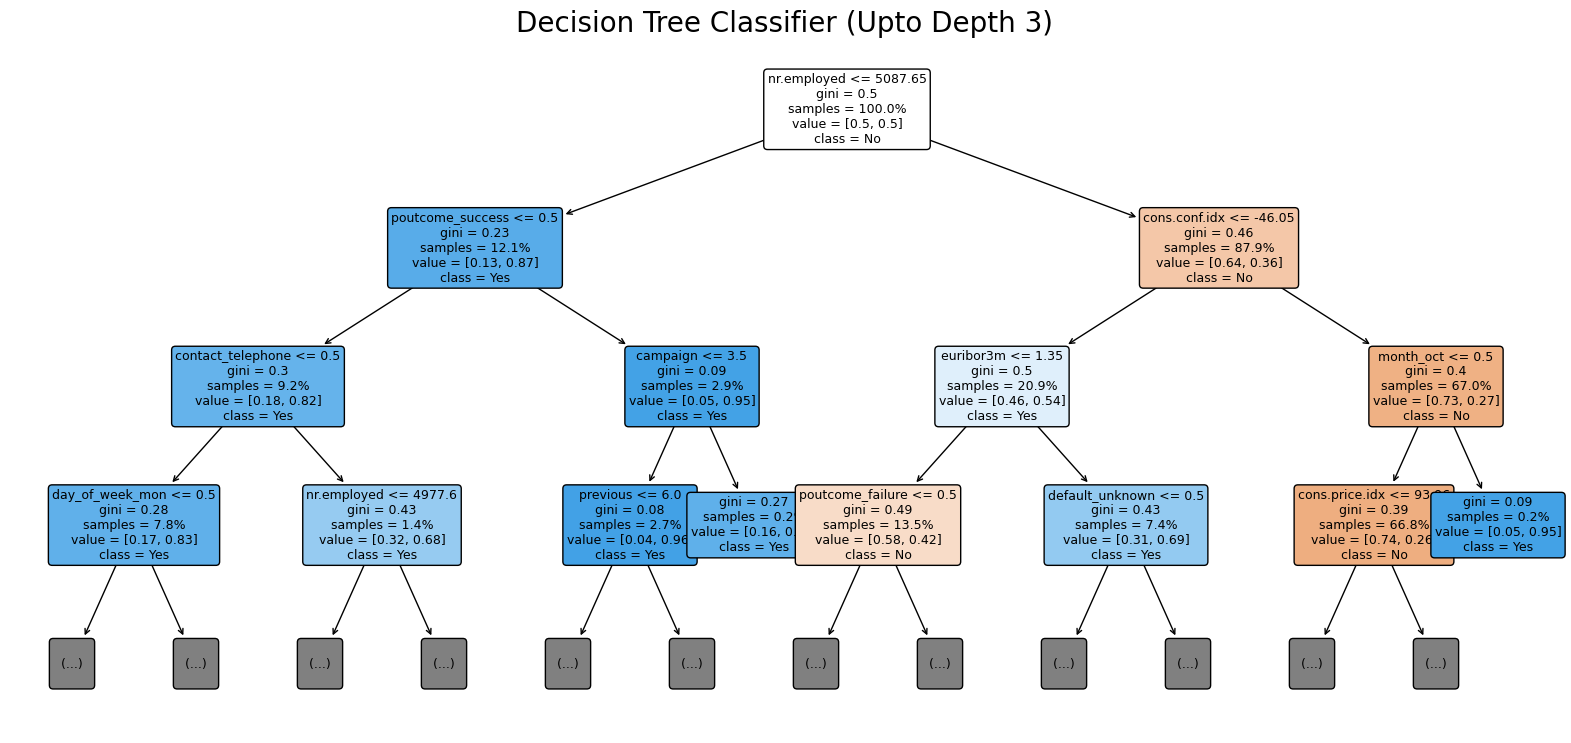

In [16]:
feature_names = tree_grid.best_estimator_[:-1].get_feature_names_out()
feature_names = [ss.replace('poly__','').replace('oe__','').replace('remainder__','') for ss in feature_names]
plt.figure(figsize= (20,9))
plot_tree(tree_grid.best_estimator_[-1], feature_names= feature_names, rounded= True, class_names= ['No', 'Yes'],
           filled= True, max_depth= 3, fontsize= 9, precision= 2, proportion= True);
plt.title("Decision Tree Classifier (Upto Depth 3)", fontsize= 20);
plt.savefig("images/tree.png")

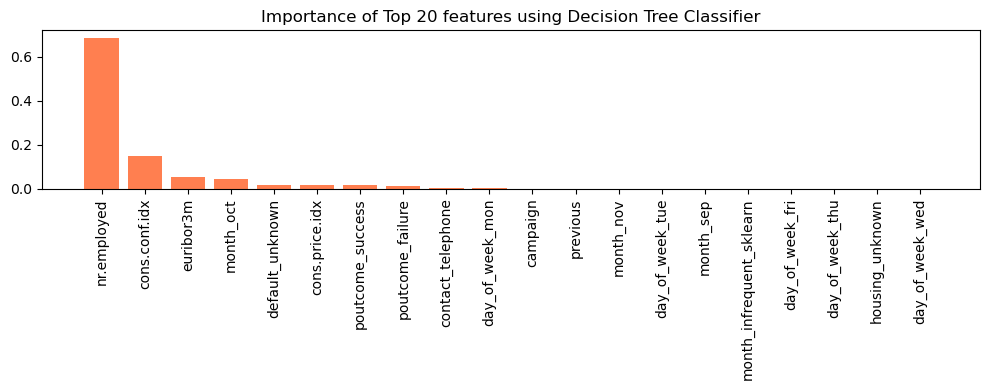

In [17]:
df_imp = pd.DataFrame(tree_grid.best_estimator_[-1].feature_importances_, index= feature_names, columns= ['importance'])
df_imp.sort_values('importance', ascending= False, inplace= True)

plt.figure(figsize= (10,4))
plt.bar(df_imp.head(20).index, df_imp.head(20)['importance'], color= 'coral')
plt.xticks(rotation= 90);
plt.title("Importance of Top 20 features using Decision Tree Classifier");
plt.tight_layout();
plt.savefig("images/tree_feature_importance.png")

### Support Vector Machine

In [37]:
#load
with open('svm.pkl', 'rb') as f:
    svm_grid = pickle.load(f)

# svm_pipe = Pipeline([
#     ('transform', col_transform),
#     ('clf', SVC(degree= 2))
# ])

# param_grid = {'clf__kernel': ['linear', 'poly', 'rbf']}
# svm_grid = GridSearchCV(svm_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_svm = svm_grid.predict(X_test)

print(svm_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for SVM: {svm_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for SVM: {svm_grid.score(X_test, y_test):0.2f}")

# # save
# with open('svm.pkl','wb') as f:
#     pickle.dump(svm_grid,f)

{'clf__kernel': 'linear'}
---------------------------------
Training F1-score for SVM: 0.33
Test F1-score for SVM: 0.30


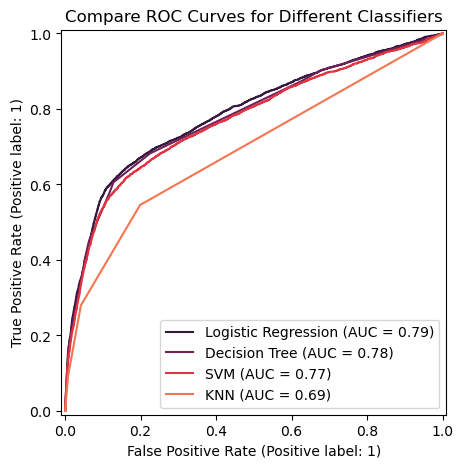

In [38]:
colors = sns.color_palette('rocket')

fig,ax = plt.subplots(figsize= (6,5))
RocCurveDisplay.from_estimator(logreg_grid, X_test, y_test, name= "Logistic Regression", ax= ax, color= colors[0])
RocCurveDisplay.from_estimator(tree_grid, X_test, y_test, name= "Decision Tree", ax= ax, color= colors[1])
RocCurveDisplay.from_estimator(svm_grid, X_test, y_test, name= "SVM", ax= ax, color= colors[3])
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, name= "KNN", ax= ax, color= colors[4])


ax.set_title("Compare ROC Curves for Different Classifiers", fontsize= 12);
fig.savefig("images/roc_curves_all.png")

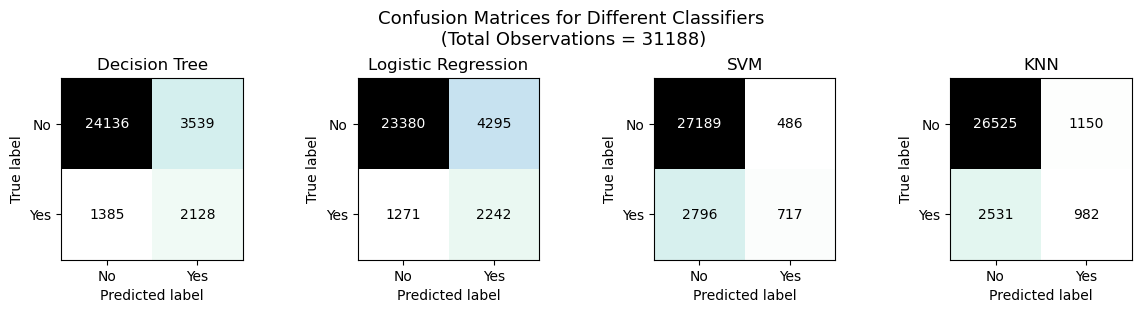

In [39]:
fig, axs = plt.subplots(figsize= (12,3), ncols= 4)

ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test, ax= axs[0], cmap= sns.color_palette('cubehelix_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[0].set_title("Decision Tree")
ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test, y_test, ax= axs[1], cmap= sns.color_palette('cubehelix_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[1].set_title("Logistic Regression")
ConfusionMatrixDisplay.from_estimator(svm_grid, X_test, y_test, ax= axs[2], cmap= sns.color_palette('cubehelix_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[2].set_title("SVM")
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test, ax= axs[3], cmap= sns.color_palette('cubehelix_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
axs[3].set_title("KNN")


plt.suptitle(f"Confusion Matrices for Different Classifiers\n (Total Observations = {X_test.shape[0]})", fontsize= 13)
plt.tight_layout();
fig.savefig("images/confusion_matrices_all.png")

### Decision Tree Model without Social and Economic Variables

In [21]:
socioeconomic_features = ['cons.conf.idx','cons.price.idx','emp.var.rate','euribor3m','nr.employed']
features = np.setdiff1d(features, socioeconomic_features)
num_features = np.setdiff1d(features, cat_features).tolist()

new_col_transform = ColumnTransformer([
    ('oe', OneHotEncoder(drop= 'if_binary', handle_unknown= 'ignore'), cat_features),
    ('poly', PolynomialFeatures(degree= 1), num_features)], remainder = 'drop')

In [94]:
# load
with open('tree_2.pkl', 'rb') as f:
    tree_grid_2 = pickle.load(f)

# tree_pipe_2 = Pipeline([
#     ('transform', new_col_transform),
#     ('clf', DecisionTreeClassifier(random_state=0, criterion= 'entropy'))
# ])

# param_grid = {'clf__max_depth': range(2,21,2), 'clf__min_samples_split': [2, 0.005, 0.01, 0.05, 0.1],
#               'clf__criterion': ['gini', 'entropy'],
#               'clf__class_weight': [None, 'balanced'],
#               'transform__poly__degree': range(1,3)}
# tree_grid_2 = GridSearchCV(tree_pipe_2, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_tree = tree_grid_2.predict(X_test)

print(tree_grid_2.best_params_)
print("---------------------------------")

print(f"Training F1-score for Tree Classifier: {tree_grid_2.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Tree Classifier: {tree_grid_2.score(X_test, y_test):0.2f}")

# # save
# with open('tree_2.pkl','wb') as f:
#     pickle.dump(tree_grid_2,f)

{'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_split': 0.05, 'transform__poly__degree': 2}
---------------------------------
Training F1-score for Tree Classifier: 0.46
Test F1-score for Tree Classifier: 0.42


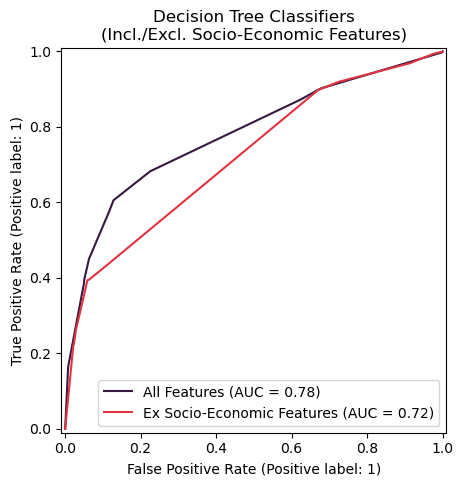

In [95]:
colors = sns.color_palette('rocket')

fig,ax = plt.subplots(figsize= (6,5))
RocCurveDisplay.from_estimator(tree_grid, X_test, y_test, name= "All Features", ax= ax, color= colors[0])
RocCurveDisplay.from_estimator(tree_grid_2, X_test, y_test, name= "Ex Socio-Economic Features", ax= ax, color= colors[3])


ax.set_title("Decision Tree Classifiers\n(Incl./Excl. Socio-Economic Features)", fontsize= 12);
fig.savefig("images/roc_curves_tree.png")

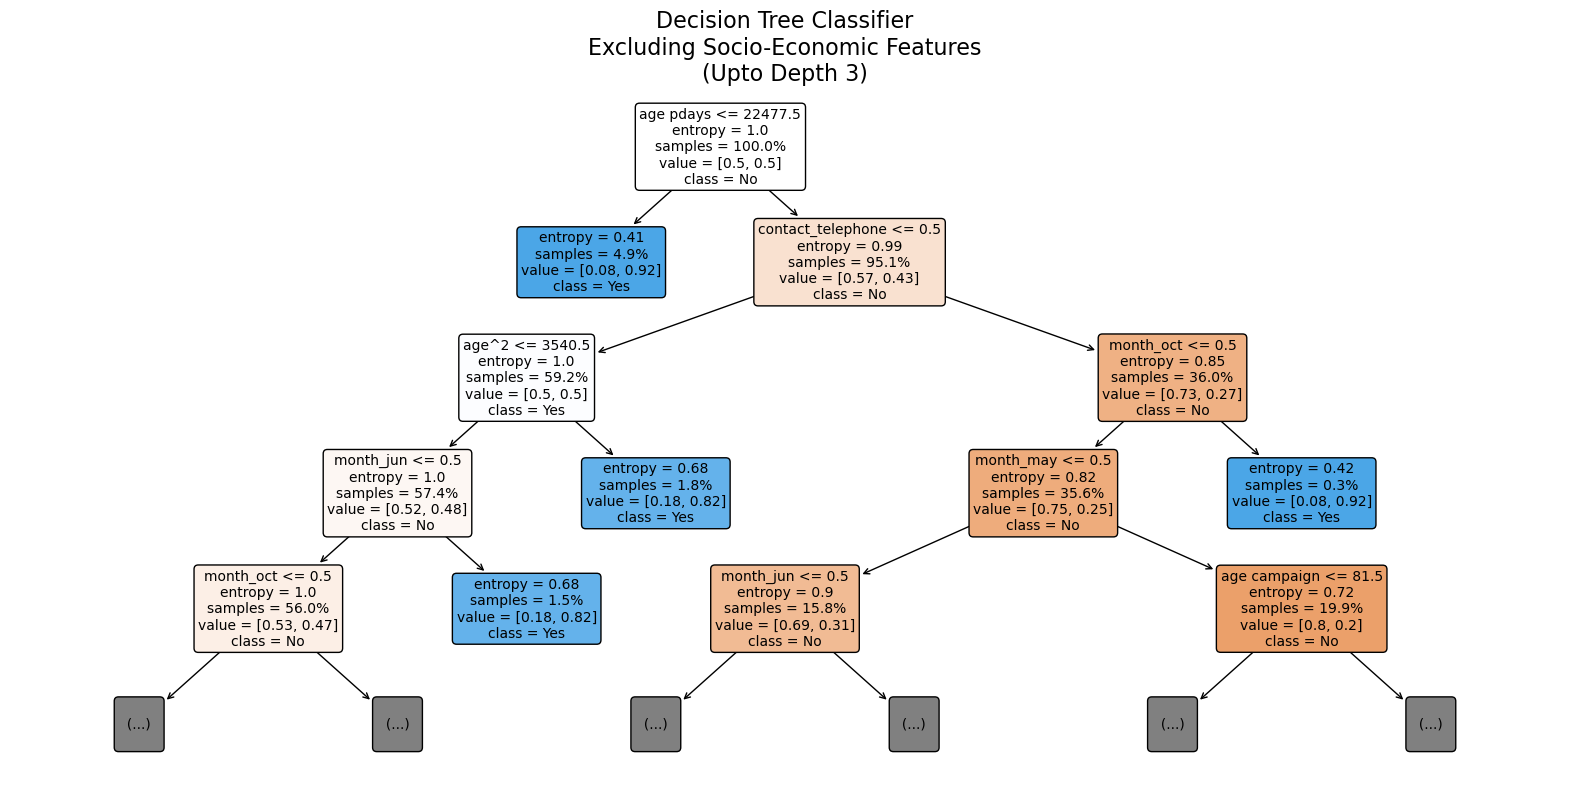

In [24]:
feature_names = tree_grid_2.best_estimator_[:-1].get_feature_names_out()
feature_names = [ss.replace('poly__','').replace('oe__','').replace('remainder__','') for ss in feature_names]
plt.figure(figsize= (20,9))
plot_tree(tree_grid_2.best_estimator_[-1], feature_names= feature_names, rounded= True, class_names= ['No', 'Yes'],
           filled= True, max_depth= 4, fontsize= 10, precision= 2, proportion= True);
plt.title("Decision Tree Classifier\nExcluding Socio-Economic Features\n(Upto Depth 3)", fontsize= 16);
plt.savefig("images/tree_exc_socio_economic.png")

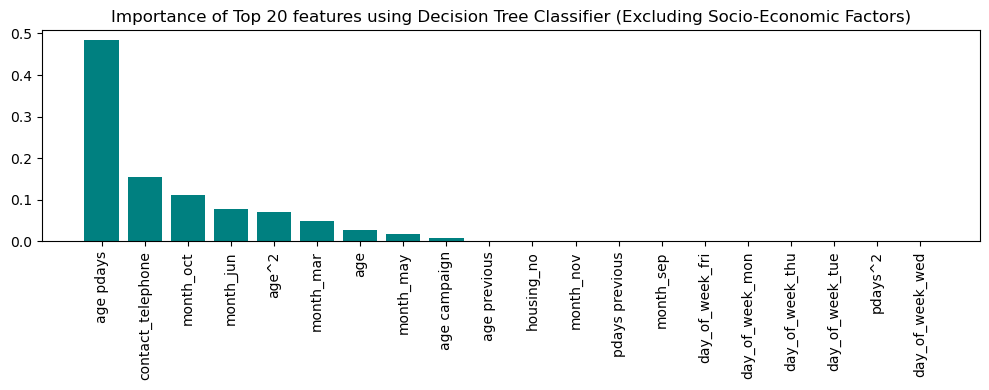

In [25]:
df_imp = pd.DataFrame(tree_grid_2.best_estimator_[-1].feature_importances_, index= feature_names, columns= ['importance'])
df_imp.sort_values('importance', ascending= False, inplace= True)

plt.figure(figsize= (10,4))
plt.bar(df_imp.head(20).index, df_imp.head(20)['importance'], color= 'teal')
plt.xticks(rotation= 90);
plt.title("Importance of Top 20 features using Decision Tree Classifier (Excluding Socio-Economic Factors)");
plt.tight_layout();
plt.savefig("images/tree_feature_importance_ex_scoio_economic.png")